In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Activation, Normalization, Discretization

from sklearn.preprocessing import MinMaxScaler

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in data tables
law=pd.read_csv('lawler.csv')
game=pd.read_csv('games.csv')

pd.options.display.max_columns = 100

#prepare data types to produce unique key
law['HomeTeamId'] = law['HomeTeamId'].astype(str)
law['VisitorTeamId'] = law['VisitorTeamId'].astype(str)

game['HOME_TEAM_ID'] = game['HOME_TEAM_ID'].astype(str)
game['VISITOR_TEAM_ID'] = game['VISITOR_TEAM_ID'].astype(str)

#produce key to join two dataframes
law['Game ID'] = law['GameDate']+law['HomeTeamId']+law['VisitorTeamId']
game['Game ID'] = game['GAME_DATE_EST']+ game['HOME_TEAM_ID'] + game['VISITOR_TEAM_ID']

#merge into singular datframe
law=law.merge(game, on = 'Game ID')

In [3]:
law.columns

Index(['GameDate', 'Home_Abbr', 'Vis_Abbr', 'HomeTeamId', 'VisitorTeamId',
       'Result', 'Lawler Law', '100 Pts', 'HomeTeamScore', 'VisitorTeamScore',
       'WinningTeamId', 'LawlerTeamId', 'HomeTeamScore_Lawler',
       'VisitorTeamScore_Lawler', 'LawlerTimeElapsed',
       'Time_Elapsed pct of game', 'Game ID', 'GAME_DATE_EST', 'GAME_ID',
       'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
       'TEAM_ID_away', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away',
       'FG3_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [4]:
#evaluate data description
law.describe()

,Result,Lawler Law,100 Pts,HomeTeamScore,VisitorTeamScore,WinningTeamId,LawlerTeamId,HomeTeamScore_Lawler,VisitorTeamScore_Lawler,LawlerTimeElapsed,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000,2.425800e+04,2.224000e+04,24258.000000,24258.000000,23825.000000,2.425800e+04,24258.000000,2.425800e+04,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000,2.425800e+04,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000,24258.000000
mean,0.511914,0.672397,0.815690,103.255833,100.386965,1.610613e+09,1.286825e+09,70.116044,67.721989,1923.897419,2.225883e+07,2011.848009,1.610613e+09,103.262099,0.461135,0.761128,0.356617,22.786091,43.358397,1.610613e+09,100.394056,0.449961,0.759383,0.350010,21.441957,42.070698,0.591228
std,0.786450,0.469349,0.387745,13.148287,13.315176,8.634848e+00,6.455055e+08,42.884260,41.730910,1142.608838,4.924324e+06,5.396810,8.644766e+00,13.140743,0.056381,0.100439,0.111635,5.189381,6.613993,8.645321e+00,13.309468,0.055284,0.103349,0.109617,5.145918,6.524295,0.491617
min,0.000000,0.000000,0.000000,39.000000,35.000000,1.610613e+09,0.000000e+00,0.000000,0.000000,0.000000,1.150000e+07,2003.000000,1.610613e+09,59.000000,0.250000,0.143000,0.000000,6.000000,17.000000,1.610613e+09,54.000000,0.244000,0.143000,0.000000,4.000000,20.000000,0.000000
25%,0.000000,0.000000,1.000000,94.000000,91.000000,1.610613e+09,1.610613e+09,0.000000,0.000000,0.000000,2.070088e+07,2007.000000,1.610613e+09,94.000000,0.422000,0.700000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.413000,0.694000,0.278000,18.000000,38.000000,0.000000
50%,0.000000,1.000000,1.000000,103.000000,100.000000,1.610613e+09,1.610613e+09,96.000000,89.000000,2486.000000,2.120103e+07,2012.000000,1.610613e+09,103.000000,0.460000,0.767000,0.357000,23.000000,43.000000,1.610613e+09,100.000000,0.449000,0.765000,0.350000,21.000000,42.000000,1.000000
75%,1.000000,1.000000,1.000000,112.000000,109.000000,1.610613e+09,1.610613e+09,100.000000,100.000000,2717.000000,2.170095e+07,2016.000000,1.610613e+09,112.000000,0.500000,0.833000,0.429000,26.000000,48.000000,1.610613e+09,109.000000,0.487000,0.833000,0.421000,25.000000,46.000000,1.000000
max,2.000000,1.000000,1.000000,168.000000,168.000000,1.610613e+09,1.610613e+09,102.000000,102.000000,3475.000000,5.200021e+07,2021.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.687000,1.000000,1.000000,46.000000,81.000000,1.000000


In [5]:
#drop unnecessary columns
todrop=['Game ID', 'GAME_ID', 'LawlerTeamId','GAME_DATE_EST','Time_Elapsed pct of game']
law.drop(todrop, axis=1, inplace=True)

In [6]:
#'Lawler Team ID' is expected to have null values.
law.isnull().sum()

GameDate                     0
Home_Abbr                    0
Vis_Abbr                     0
HomeTeamId                   0
VisitorTeamId                0
Result                       0
Lawler Law                   0
100 Pts                      0
HomeTeamScore                0
VisitorTeamScore             0
WinningTeamId                0
HomeTeamScore_Lawler         0
VisitorTeamScore_Lawler      0
LawlerTimeElapsed          433
HOME_TEAM_ID                 0
VISITOR_TEAM_ID              0
SEASON                       0
TEAM_ID_home                 0
PTS_home                     0
FG_PCT_home                  0
FT_PCT_home                  0
FG3_PCT_home                 0
AST_home                     0
REB_home                     0
TEAM_ID_away                 0
PTS_away                     0
FG_PCT_away                  0
FT_PCT_away                  0
FG3_PCT_away                 0
AST_away                     0
REB_away                     0
HOME_TEAM_WINS               0
dtype: i

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Result', ylabel='count'>

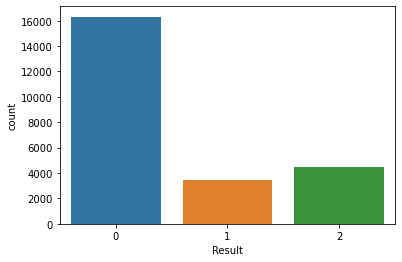

In [7]:
#ratio of instances where Lawler's Law holds true (1), 
#to where the team that scored 100 pts loses (2), 
#and where 100 points aren't scored(3).
sns.countplot(law['Result'])

In [8]:

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer=imputer.fit(law[['LawlerTimeElapsed']])
law['LawlerTimeElapsed']= imputer.transform(law[['LawlerTimeElapsed']])


In [9]:
#identify data and target
X = law.iloc[:,8:len(law)]
y = law.iloc[:, 5]

In [10]:
#for DNN to be built, data must be appropriately scaled & normalized to mean 0, unit variance 
scaler = MinMaxScaler()
X =scaler.fit_transform(X)

X=sklearn.preprocessing.normalize(X)

In [11]:
#split into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [12]:
#split 3 classes in target column into np. array
num_classes=3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
#define vanilla model
model = Sequential([
    Dense(32, input_shape=(24,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax'),
])

model.compile('adam','categorical_crossentropy', metrics =['accuracy'] )

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                800       
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 899
Trainable params: 899
Non-trainable params: 0
_________________________________________________________________


In [15]:
import tensorflow as tf
#Considering y variable holds numpy array, now must transform to tensor
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


In [16]:
#fit Vanilla
model.fit(X_train, y_tensor, batch_size=128, epochs=100, verbose =1)

Epoch 1/100
152/152 [==============================] - 0s 739us/step - loss: 0.7334 - accuracy: 0.7165
Epoch 2/100
152/152 [==============================] - 0s 690us/step - loss: 0.4566 - accuracy: 0.8598
Epoch 3/100
152/152 [==============================] - 0s 647us/step - loss: 0.3748 - accuracy: 0.8748
Epoch 4/100
152/152 [==============================] - 0s 621us/step - loss: 0.3455 - accuracy: 0.8777
Epoch 5/100
152/152 [==============================] - 0s 593us/step - loss: 0.3287 - accuracy: 0.8887
Epoch 6/100
152/152 [==============================] - 0s 680us/step - loss: 0.3175 - accuracy: 0.8979
Epoch 7/100
152/152 [==============================] - 0s 654us/step - loss: 0.3097 - accuracy: 0.9026
Epoch 8/100
152/152 [==============================] - 0s 680us/step - loss: 0.3041 - accuracy: 0.9042
Epoch 9/100
152/152 [==============================] - 0s 595us/step - loss: 0.3003 - accuracy: 0.9049
Epoch 10/100
152/152 [==============================] - 0s 661us/step - l

In [17]:
#develop tuned DNN model using KerasClassifier and GridSearch CV

def make_model(optimizer="adam", hidden_size=32):
    model = Sequential([
        Dense(hidden_size, input_shape=(24,)),
        Activation('relu'),
        Dense(3),
        Activation('softmax'),
    ])
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)

param_grid = {'epochs': [1, 5, 10, 100],  # epochs is fit parameter, not in make_model!
              'hidden_size': [32, 64, 256, 1028]}

grid = GridSearchCV(clf, param_grid=param_grid,return_train_score=True)

C:\Users\trevo\AppData\Local\Temp\ipykernel_22240\2380081534.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(make_model)


In [18]:
#fit the GridSearchCV model
grid.fit(X_train, y_train)

486/486 [==============================] - 0s 604us/step - loss: 0.3117 - accuracy: 0.9063
Epoch 1/5
486/486 [==============================] - 1s 678us/step - loss: 0.5741 - accuracy: 0.7942
Epoch 2/5
486/486 [==============================] - 0s 638us/step - loss: 0.3580 - accuracy: 0.8779
Epoch 3/5
486/486 [==============================] - 0s 640us/step - loss: 0.3257 - accuracy: 0.8917
Epoch 4/5
486/486 [==============================] - 0s 635us/step - loss: 0.3101 - accuracy: 0.9019
Epoch 5/5
486/486 [==============================] - 0s 572us/step - loss: 0.3019 - accuracy: 0.9047
Epoch 1/5
486/486 [==============================] - 1s 645us/step - loss: 0.5496 - accuracy: 0.8048
Epoch 2/5
486/486 [==============================] - 0s 640us/step - loss: 0.3572 - accuracy: 0.8774
Epoch 3/5
486/486 [==============================] - 0s 642us/step - loss: 0.3261 - accuracy: 0.8896
Epoch 4/5
486/486 [==============================] - 0s 656us/step - loss: 0.3091 - accuracy: 0.9013


486/486 [==============================] - 0s 612us/step - loss: 0.2477 - accuracy: 0.9108
Epoch 1/5
486/486 [==============================] - 1s 800us/step - loss: 0.3685 - accuracy: 0.8779
Epoch 2/5
486/486 [==============================] - 0s 783us/step - loss: 0.2961 - accuracy: 0.9058
Epoch 3/5
486/486 [==============================] - 0s 783us/step - loss: 0.2866 - accuracy: 0.9045
Epoch 4/5
486/486 [==============================] - 0s 785us/step - loss: 0.2751 - accuracy: 0.9054
Epoch 5/5
486/486 [==============================] - 0s 602us/step - loss: 0.2507 - accuracy: 0.9036
Epoch 1/5
486/486 [==============================] - 1s 809us/step - loss: 0.3666 - accuracy: 0.8777
Epoch 2/5
486/486 [==============================] - 0s 774us/step - loss: 0.2975 - accuracy: 0.9049
Epoch 3/5
486/486 [==============================] - 0s 771us/step - loss: 0.2870 - accuracy: 0.9047
Epoch 4/5
486/486 [==============================] - 0s 773us/step - loss: 0.2761 - accuracy: 0.9056


486/486 [==============================] - 0s 666us/step - loss: 0.3034 - accuracy: 0.9030
Epoch 3/10
486/486 [==============================] - 0s 669us/step - loss: 0.2956 - accuracy: 0.9036
Epoch 4/10
486/486 [==============================] - 0s 676us/step - loss: 0.2884 - accuracy: 0.9057
Epoch 5/10
486/486 [==============================] - 0s 665us/step - loss: 0.2843 - accuracy: 0.9056
Epoch 6/10
486/486 [==============================] - 0s 668us/step - loss: 0.2780 - accuracy: 0.9056
Epoch 7/10
486/486 [==============================] - 0s 672us/step - loss: 0.2708 - accuracy: 0.9058
Epoch 8/10
486/486 [==============================] - 0s 674us/step - loss: 0.2652 - accuracy: 0.9061
Epoch 9/10
486/486 [==============================] - 0s 665us/step - loss: 0.2559 - accuracy: 0.9071
Epoch 10/10
486/486 [==============================] - 0s 552us/step - loss: 0.2425 - accuracy: 0.9042
Epoch 1/10
486/486 [==============================] - 1s 688us/step - loss: 0.4302 - accurac

Epoch 55/100
486/486 [==============================] - 0s 629us/step - loss: 0.1996 - accuracy: 0.9163
Epoch 56/100
486/486 [==============================] - 0s 627us/step - loss: 0.1983 - accuracy: 0.9161
Epoch 57/100
486/486 [==============================] - 0s 629us/step - loss: 0.1972 - accuracy: 0.9170
Epoch 58/100
486/486 [==============================] - 0s 627us/step - loss: 0.1959 - accuracy: 0.9177
Epoch 59/100
486/486 [==============================] - 0s 624us/step - loss: 0.1955 - accuracy: 0.9178
Epoch 60/100
486/486 [==============================] - 0s 625us/step - loss: 0.1941 - accuracy: 0.9174
Epoch 61/100
486/486 [==============================] - 0s 625us/step - loss: 0.1939 - accuracy: 0.9178
Epoch 62/100
486/486 [==============================] - 0s 636us/step - loss: 0.1919 - accuracy: 0.9190
Epoch 63/100
486/486 [==============================] - 0s 629us/step - loss: 0.1918 - accuracy: 0.9185
Epoch 64/100
486/486 [==============================] - 0s 625us

486/486 [==============================] - 0s 638us/step - loss: 0.2285 - accuracy: 0.9085
Epoch 33/100
486/486 [==============================] - 0s 638us/step - loss: 0.2258 - accuracy: 0.9081
Epoch 34/100
486/486 [==============================] - 0s 638us/step - loss: 0.2252 - accuracy: 0.9074
Epoch 35/100
486/486 [==============================] - 0s 636us/step - loss: 0.2238 - accuracy: 0.9089
Epoch 36/100
486/486 [==============================] - 0s 635us/step - loss: 0.2220 - accuracy: 0.9092
Epoch 37/100
486/486 [==============================] - 0s 639us/step - loss: 0.2203 - accuracy: 0.9089
Epoch 38/100
486/486 [==============================] - 0s 636us/step - loss: 0.2193 - accuracy: 0.9090
Epoch 39/100
486/486 [==============================] - 0s 639us/step - loss: 0.2183 - accuracy: 0.9092
Epoch 40/100
486/486 [==============================] - 0s 639us/step - loss: 0.2163 - accuracy: 0.9103
Epoch 41/100
486/486 [==============================] - 0s 636us/step - loss:

486/486 [==============================] - 0s 635us/step - loss: 0.1721 - accuracy: 0.9261
Epoch 88/100
486/486 [==============================] - 0s 637us/step - loss: 0.1710 - accuracy: 0.9266
Epoch 89/100
486/486 [==============================] - 0s 638us/step - loss: 0.1704 - accuracy: 0.9279
Epoch 90/100
486/486 [==============================] - 0s 633us/step - loss: 0.1697 - accuracy: 0.9274
Epoch 91/100
486/486 [==============================] - 0s 637us/step - loss: 0.1683 - accuracy: 0.9272
Epoch 92/100
486/486 [==============================] - 0s 636us/step - loss: 0.1675 - accuracy: 0.9283
Epoch 93/100
486/486 [==============================] - 0s 633us/step - loss: 0.1669 - accuracy: 0.9275
Epoch 94/100
486/486 [==============================] - 0s 632us/step - loss: 0.1656 - accuracy: 0.9300
Epoch 95/100
486/486 [==============================] - 0s 639us/step - loss: 0.1638 - accuracy: 0.9301
Epoch 96/100
486/486 [==============================] - 0s 639us/step - loss:

486/486 [==============================] - 0s 633us/step - loss: 0.2210 - accuracy: 0.9093
Epoch 42/100
486/486 [==============================] - 0s 629us/step - loss: 0.2190 - accuracy: 0.9090
Epoch 43/100
486/486 [==============================] - 0s 625us/step - loss: 0.2174 - accuracy: 0.9094
Epoch 44/100
486/486 [==============================] - 0s 632us/step - loss: 0.2161 - accuracy: 0.9105
Epoch 45/100
486/486 [==============================] - 0s 626us/step - loss: 0.2145 - accuracy: 0.9112
Epoch 46/100
486/486 [==============================] - 0s 631us/step - loss: 0.2135 - accuracy: 0.9110
Epoch 47/100
486/486 [==============================] - 0s 634us/step - loss: 0.2124 - accuracy: 0.9115
Epoch 48/100
486/486 [==============================] - 0s 631us/step - loss: 0.2111 - accuracy: 0.9120
Epoch 49/100
486/486 [==============================] - 0s 632us/step - loss: 0.2101 - accuracy: 0.9124
Epoch 50/100
486/486 [==============================] - 0s 631us/step - loss:

486/486 [==============================] - 0s 657us/step - loss: 0.1284 - accuracy: 0.9487
Epoch 97/100
486/486 [==============================] - 0s 650us/step - loss: 0.1278 - accuracy: 0.9489
Epoch 98/100
486/486 [==============================] - 0s 656us/step - loss: 0.1274 - accuracy: 0.9483
Epoch 99/100
486/486 [==============================] - 0s 661us/step - loss: 0.1265 - accuracy: 0.9499
Epoch 100/100
486/486 [==============================] - 0s 577us/step - loss: 0.1227 - accuracy: 0.9476
Epoch 1/100
486/486 [==============================] - 1s 672us/step - loss: 0.5074 - accuracy: 0.8171
Epoch 2/100
486/486 [==============================] - 0s 655us/step - loss: 0.3351 - accuracy: 0.8855
Epoch 3/100
486/486 [==============================] - 0s 641us/step - loss: 0.3102 - accuracy: 0.9010
Epoch 4/100
486/486 [==============================] - 0s 643us/step - loss: 0.3000 - accuracy: 0.9042
Epoch 5/100
486/486 [==============================] - 0s 654us/step - loss: 0.2

486/486 [==============================] - 0s 629us/step - loss: 0.1793 - accuracy: 0.9217
Epoch 51/100
486/486 [==============================] - 0s 627us/step - loss: 0.1774 - accuracy: 0.9233
Epoch 52/100
486/486 [==============================] - 0s 629us/step - loss: 0.1761 - accuracy: 0.9230
Epoch 53/100
486/486 [==============================] - 0s 632us/step - loss: 0.1744 - accuracy: 0.9251
Epoch 54/100
486/486 [==============================] - 0s 629us/step - loss: 0.1726 - accuracy: 0.9241
Epoch 55/100
486/486 [==============================] - 0s 629us/step - loss: 0.1719 - accuracy: 0.9237
Epoch 56/100
486/486 [==============================] - 0s 629us/step - loss: 0.1701 - accuracy: 0.9257
Epoch 57/100
486/486 [==============================] - 0s 627us/step - loss: 0.1683 - accuracy: 0.9277
Epoch 58/100
486/486 [==============================] - 0s 633us/step - loss: 0.1675 - accuracy: 0.9272
Epoch 59/100
486/486 [==============================] - 0s 625us/step - loss:

486/486 [==============================] - 0s 641us/step - loss: 0.2959 - accuracy: 0.9037
Epoch 5/100
486/486 [==============================] - 0s 643us/step - loss: 0.2904 - accuracy: 0.9058
Epoch 6/100
486/486 [==============================] - 0s 641us/step - loss: 0.2875 - accuracy: 0.9045
Epoch 7/100
486/486 [==============================] - 0s 645us/step - loss: 0.2831 - accuracy: 0.9053
Epoch 8/100
486/486 [==============================] - 0s 641us/step - loss: 0.2793 - accuracy: 0.9056
Epoch 9/100
486/486 [==============================] - 0s 643us/step - loss: 0.2750 - accuracy: 0.9059
Epoch 10/100
486/486 [==============================] - 0s 639us/step - loss: 0.2717 - accuracy: 0.9060
Epoch 11/100
486/486 [==============================] - 0s 640us/step - loss: 0.2676 - accuracy: 0.9063
Epoch 12/100
486/486 [==============================] - 0s 643us/step - loss: 0.2630 - accuracy: 0.9069
Epoch 13/100
486/486 [==============================] - 0s 641us/step - loss: 0.25

Epoch 83/100
486/486 [==============================] - 0s 641us/step - loss: 0.1477 - accuracy: 0.9386
Epoch 84/100
486/486 [==============================] - 0s 644us/step - loss: 0.1455 - accuracy: 0.9385
Epoch 85/100
486/486 [==============================] - 0s 659us/step - loss: 0.1457 - accuracy: 0.9401
Epoch 86/100
486/486 [==============================] - 0s 642us/step - loss: 0.1446 - accuracy: 0.9399
Epoch 87/100
486/486 [==============================] - 0s 641us/step - loss: 0.1440 - accuracy: 0.9400
Epoch 88/100
486/486 [==============================] - 0s 641us/step - loss: 0.1414 - accuracy: 0.9431
Epoch 89/100
486/486 [==============================] - 0s 644us/step - loss: 0.1421 - accuracy: 0.9404
Epoch 90/100
486/486 [==============================] - 0s 649us/step - loss: 0.1401 - accuracy: 0.9427
Epoch 91/100
486/486 [==============================] - 0s 643us/step - loss: 0.1403 - accuracy: 0.9405
Epoch 92/100
486/486 [==============================] - 0s 643us

486/486 [==============================] - 0s 684us/step - loss: 0.1278 - accuracy: 0.9491
Epoch 61/100
486/486 [==============================] - 0s 684us/step - loss: 0.1281 - accuracy: 0.9482
Epoch 62/100
486/486 [==============================] - 0s 686us/step - loss: 0.1250 - accuracy: 0.9501
Epoch 63/100
486/486 [==============================] - 0s 682us/step - loss: 0.1247 - accuracy: 0.9495
Epoch 64/100
486/486 [==============================] - 0s 680us/step - loss: 0.1252 - accuracy: 0.9498
Epoch 65/100
486/486 [==============================] - 0s 688us/step - loss: 0.1246 - accuracy: 0.9487
Epoch 66/100
486/486 [==============================] - 0s 684us/step - loss: 0.1226 - accuracy: 0.9505
Epoch 67/100
486/486 [==============================] - 0s 696us/step - loss: 0.1226 - accuracy: 0.9509
Epoch 68/100
486/486 [==============================] - 0s 688us/step - loss: 0.1202 - accuracy: 0.9509
Epoch 69/100
486/486 [==============================] - 0s 690us/step - loss:

486/486 [==============================] - 0s 683us/step - loss: 0.2302 - accuracy: 0.9083
Epoch 15/100
486/486 [==============================] - 0s 716us/step - loss: 0.2256 - accuracy: 0.9071
Epoch 16/100
486/486 [==============================] - 0s 738us/step - loss: 0.2225 - accuracy: 0.9098
Epoch 17/100
486/486 [==============================] - 0s 862us/step - loss: 0.2186 - accuracy: 0.9094
Epoch 18/100
486/486 [==============================] - 0s 886us/step - loss: 0.2147 - accuracy: 0.9106
Epoch 19/100
486/486 [==============================] - 0s 722us/step - loss: 0.2114 - accuracy: 0.9113
Epoch 20/100
486/486 [==============================] - 0s 723us/step - loss: 0.2083 - accuracy: 0.9116
Epoch 21/100
486/486 [==============================] - 0s 681us/step - loss: 0.2043 - accuracy: 0.9123
Epoch 22/100
486/486 [==============================] - 0s 681us/step - loss: 0.2021 - accuracy: 0.9142
Epoch 23/100
486/486 [==============================] - 0s 695us/step - loss:

486/486 [==============================] - 0s 676us/step - loss: 0.1150 - accuracy: 0.9539
Epoch 70/100
486/486 [==============================] - 0s 676us/step - loss: 0.1145 - accuracy: 0.9541
Epoch 71/100
486/486 [==============================] - 0s 676us/step - loss: 0.1163 - accuracy: 0.9539
Epoch 72/100
486/486 [==============================] - 0s 711us/step - loss: 0.1129 - accuracy: 0.9552
Epoch 73/100
486/486 [==============================] - 0s 711us/step - loss: 0.1138 - accuracy: 0.9548
Epoch 74/100
486/486 [==============================] - 0s 681us/step - loss: 0.1115 - accuracy: 0.9566
Epoch 75/100
486/486 [==============================] - 0s 678us/step - loss: 0.1110 - accuracy: 0.9562
Epoch 76/100
486/486 [==============================] - 0s 674us/step - loss: 0.1121 - accuracy: 0.9538
Epoch 77/100
486/486 [==============================] - 0s 682us/step - loss: 0.1093 - accuracy: 0.9583
Epoch 78/100
486/486 [==============================] - 0s 681us/step - loss:

486/486 [==============================] - 0s 798us/step - loss: 0.1644 - accuracy: 0.9300
Epoch 24/100
486/486 [==============================] - 0s 796us/step - loss: 0.1597 - accuracy: 0.9327
Epoch 25/100
486/486 [==============================] - 0s 796us/step - loss: 0.1602 - accuracy: 0.9315
Epoch 26/100
486/486 [==============================] - 0s 810us/step - loss: 0.1558 - accuracy: 0.9344
Epoch 27/100
486/486 [==============================] - 0s 796us/step - loss: 0.1546 - accuracy: 0.9353
Epoch 28/100
486/486 [==============================] - 0s 802us/step - loss: 0.1505 - accuracy: 0.9382
Epoch 29/100
486/486 [==============================] - 0s 801us/step - loss: 0.1478 - accuracy: 0.9380
Epoch 30/100
486/486 [==============================] - 0s 814us/step - loss: 0.1463 - accuracy: 0.9390
Epoch 31/100
486/486 [==============================] - 0s 796us/step - loss: 0.1449 - accuracy: 0.9407
Epoch 32/100
486/486 [==============================] - 0s 802us/step - loss:

486/486 [==============================] - 0s 800us/step - loss: 0.0978 - accuracy: 0.9605
Epoch 80/100
486/486 [==============================] - 0s 798us/step - loss: 0.0952 - accuracy: 0.9617
Epoch 81/100
486/486 [==============================] - 0s 825us/step - loss: 0.0981 - accuracy: 0.9601
Epoch 82/100
486/486 [==============================] - 0s 800us/step - loss: 0.0958 - accuracy: 0.9616
Epoch 83/100
486/486 [==============================] - 0s 798us/step - loss: 0.0937 - accuracy: 0.9620
Epoch 84/100
486/486 [==============================] - 0s 794us/step - loss: 0.0939 - accuracy: 0.9623
Epoch 85/100
486/486 [==============================] - 0s 810us/step - loss: 0.0945 - accuracy: 0.9612
Epoch 86/100
486/486 [==============================] - 0s 802us/step - loss: 0.0923 - accuracy: 0.9624
Epoch 87/100
486/486 [==============================] - 0s 808us/step - loss: 0.0914 - accuracy: 0.9617
Epoch 88/100
486/486 [==============================] - 0s 818us/step - loss:

486/486 [==============================] - 0s 775us/step - loss: 0.1345 - accuracy: 0.9454
Epoch 34/100
486/486 [==============================] - 0s 767us/step - loss: 0.1314 - accuracy: 0.9460
Epoch 35/100
486/486 [==============================] - 0s 772us/step - loss: 0.1324 - accuracy: 0.9462
Epoch 36/100
486/486 [==============================] - 0s 776us/step - loss: 0.1290 - accuracy: 0.9476
Epoch 37/100
486/486 [==============================] - 0s 766us/step - loss: 0.1275 - accuracy: 0.9484
Epoch 38/100
486/486 [==============================] - 0s 765us/step - loss: 0.1256 - accuracy: 0.9494
Epoch 39/100
486/486 [==============================] - 0s 771us/step - loss: 0.1255 - accuracy: 0.9483
Epoch 40/100
486/486 [==============================] - 0s 771us/step - loss: 0.1236 - accuracy: 0.9492
Epoch 41/100
486/486 [==============================] - 0s 772us/step - loss: 0.1236 - accuracy: 0.9495
Epoch 42/100
486/486 [==============================] - 0s 774us/step - loss:

486/486 [==============================] - 0s 917us/step - loss: 0.0943 - accuracy: 0.9613
Epoch 90/100
486/486 [==============================] - 0s 888us/step - loss: 0.0911 - accuracy: 0.9621
Epoch 91/100
486/486 [==============================] - 0s 923us/step - loss: 0.0901 - accuracy: 0.9623
Epoch 92/100
486/486 [==============================] - 0s 823us/step - loss: 0.0950 - accuracy: 0.9602
Epoch 93/100
486/486 [==============================] - 0s 796us/step - loss: 0.0912 - accuracy: 0.9629
Epoch 94/100
486/486 [==============================] - 0s 810us/step - loss: 0.0941 - accuracy: 0.9595
Epoch 95/100
486/486 [==============================] - 0s 800us/step - loss: 0.0895 - accuracy: 0.9624
Epoch 96/100
486/486 [==============================] - 0s 804us/step - loss: 0.0889 - accuracy: 0.9637
Epoch 97/100
486/486 [==============================] - 0s 794us/step - loss: 0.0910 - accuracy: 0.9626
Epoch 98/100
486/486 [==============================] - 0s 796us/step - loss:

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001AC457A7DF0>,
             param_grid={'epochs': [1, 5, 10, 100],
                         'hidden_size': [32, 64, 256, 1028]},
             return_train_score=True)

In [19]:

res = pd.DataFrame(grid.cv_results_)

res


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_hidden_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.660683,0.005363,0.207593,0.009578,1,32,"{'epochs': 1, 'hidden_size': 32}",0.859866,0.875548,0.881989,0.870910,0.879155,0.873493,0.007757,16,0.863051,0.876329,0.874589,0.874267,0.879098,0.873467,0.005483
1,0.691058,0.062795,0.202727,0.000686,1,64,"{'epochs': 1, 'hidden_size': 64}",0.873261,0.878124,0.882762,0.878382,0.877867,0.878079,0.003009,15,0.877931,0.879936,0.875040,0.879742,0.876844,0.877899,0.001835
2,0.673472,0.004650,0.204871,0.001012,1,256,"{'epochs': 1, 'hidden_size': 256}",0.889490,0.880186,0.896934,0.900283,0.898222,0.893023,0.007380,14,0.894228,0.882770,0.889662,0.906216,0.895717,0.893718,0.007704
3,0.772206,0.064462,0.215101,0.010546,1,1028,"{'epochs': 1, 'hidden_size': 1028}",0.901082,0.907498,0.906210,0.906725,0.907240,0.905751,0.002376,9,0.902989,0.904734,0.905443,0.906924,0.906280,0.905274,0.001362
4,1.951172,0.073926,0.202919,0.002087,5,32,"{'epochs': 5, 'hidden_size': 32}",0.902112,0.903891,0.909044,0.897191,0.905694,0.903587,0.003934,13,0.904728,0.904155,0.903382,0.901063,0.904992,0.903664,0.001413
5,1.950798,0.069765,0.232211,0.058736,5,64,"{'epochs': 5, 'hidden_size': 64}",0.901340,0.903891,0.905952,0.905694,0.905694,0.904514,0.001750,12,0.904793,0.904734,0.905636,0.908599,0.904026,0.905558,0.001604
6,1.979618,0.007451,0.204600,0.001716,5,256,"{'epochs': 5, 'hidden_size': 256}",0.905719,0.907498,0.908271,0.907498,0.905694,0.906936,0.001043,6,0.911041,0.906345,0.903060,0.909952,0.904928,0.907065,0.003009
7,2.240753,0.008543,0.206891,0.001625,5,1028,"{'epochs': 5, 'hidden_size': 1028}",0.904946,0.905179,0.910590,0.900283,0.905179,0.905236,0.003264,10,0.910783,0.903575,0.908599,0.907311,0.903897,0.906833,0.002764
8,3.496745,0.065490,0.201332,0.001508,10,32,"{'epochs': 10, 'hidden_size': 32}",0.903658,0.909302,0.908786,0.901572,0.907756,0.906215,0.003053,7,0.906725,0.907118,0.902673,0.906473,0.906087,0.905815,0.001606
9,3.486283,0.013686,0.232868,0.059957,10,64,"{'epochs': 10, 'hidden_size': 64}",0.901082,0.905179,0.910075,0.900026,0.909044,0.905081,0.004055,11,0.905630,0.904348,0.904090,0.905314,0.906602,0.905197,0.000908


In [20]:
res.pivot_table(index=["param_epochs", "param_hidden_size"],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_hidden_size                                   
1            32                        0.873493          0.873467
             64                        0.878079          0.877899
             256                       0.893023          0.893718
             1028                      0.905751          0.905274
5            32                        0.903587          0.903664
             64                        0.904514          0.905558
             256                       0.906936          0.907065
             1028                      0.905236          0.906833
10           32                        0.906215          0.905815
             64                        0.905081          0.905197
             256                       0.905957          0.906382
             1028                      0.911574          0.912746
100          32                        0.932238          0.933706
             64                        0.945584          0.948251
             256                       0.958415          0.961056
             1028                      0.958518          0.964392

In [21]:
print(grid.score(X_test, y_test))

152/152 [==============================] - 0s 640us/step - loss: 0.1003 - accuracy: 0.9555
0.9554823040962219


# decision Tree to Help Visualize & learn the key features


In [22]:
todrop=['WinningTeamId','HOME_TEAM_ID','TEAM_ID_away','HOME_TEAM_WINS','VISITOR_TEAM_ID','TEAM_ID_home','SEASON','HomeTeamScore_Lawler','VisitorTeamScore_Lawler','LawlerTimeElapsed','HomeTeamScore','VisitorTeamScore','PTS_home','PTS_away','GameDate']
law.drop(todrop, axis=1, inplace=True)


In [23]:
X = law.iloc[:,7:len(law)]
y = law.iloc[:, 6]

In [24]:
#split into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [25]:
X_train

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
22616,0.420,0.733,0.234,24.0,37.0,0.551,0.813,0.484,30.0,49.0
6060,0.456,0.794,0.560,23.0,45.0,0.426,0.806,0.345,19.0,50.0
24127,0.547,0.906,0.424,23.0,30.0,0.537,0.875,0.357,30.0,41.0
22334,0.514,0.714,0.500,29.0,50.0,0.453,0.889,0.366,30.0,52.0
15736,0.433,0.658,0.375,20.0,48.0,0.500,0.739,0.500,19.0,38.0
...,...,...,...,...,...,...,...,...,...,...
21961,0.495,0.900,0.406,28.0,59.0,0.404,0.905,0.292,18.0,37.0
16286,0.434,0.680,0.324,23.0,41.0,0.379,0.933,0.385,14.0,49.0
3932,0.380,0.923,0.400,23.0,40.0,0.462,0.900,0.429,18.0,37.0
17987,0.465,0.867,0.500,20.0,32.0,0.494,0.706,0.455,30.0,44.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='param_max_depth'>

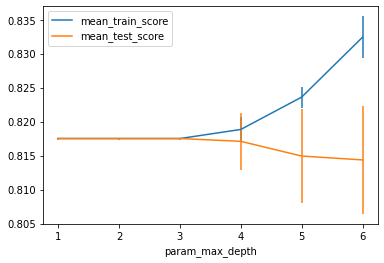

In [26]:
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_depth', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [27]:
best=grid.best_params_
best

{'max_depth': 1}

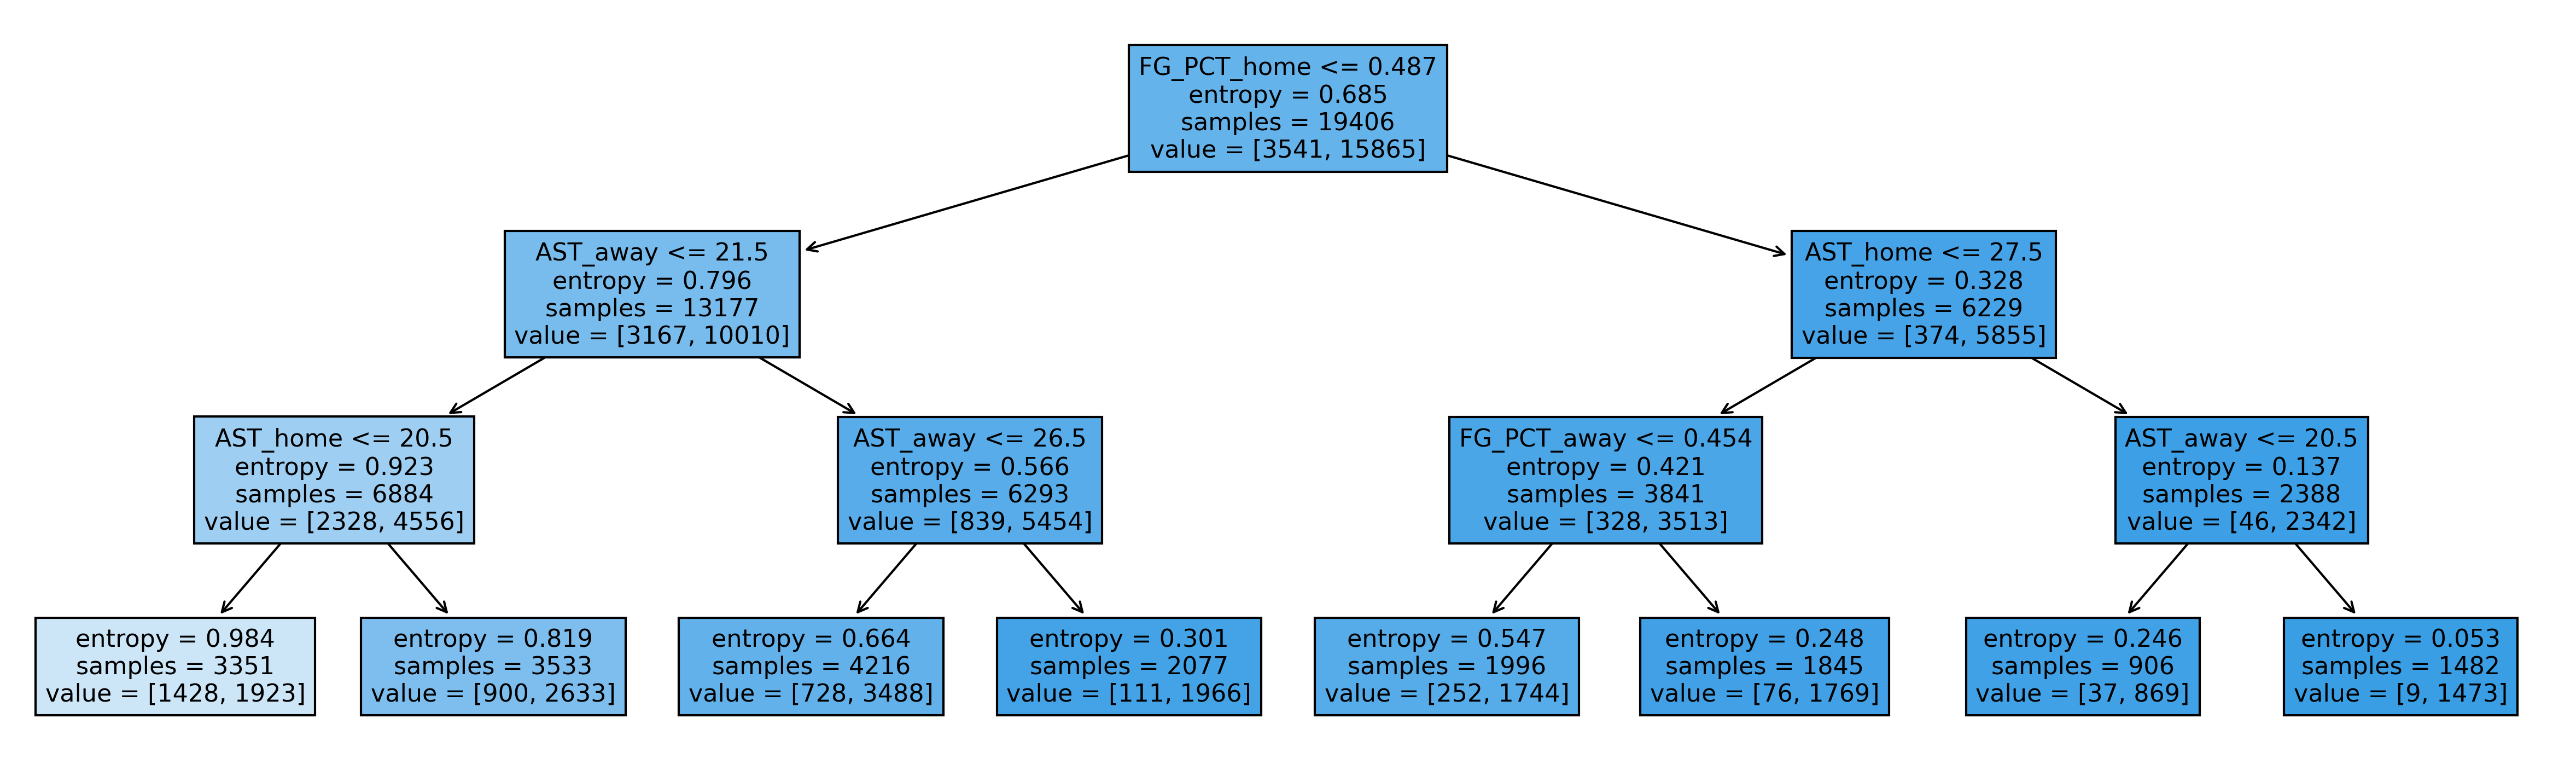

In [28]:

tree = DecisionTreeClassifier(max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)

plt.figure(figsize=(20, 6), dpi=300)
tree_dot = plot_tree(tree, feature_names=X_train.columns, filled=True)
